In [1]:
import os
from glob import glob
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# import sys
# sys.path.sort()
# sys.path.insert(1, os.path.join(sys.path[0], '../../'))

In [3]:
# Set a seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
import utils

In [5]:
img_base_dir = './train/vision'        # Change according to your path.
audio_base_dir = './train/sound'       # Change according to your path.
class_labels = [f for f in os.listdir(img_base_dir) if os.path.isdir(os.path.join(img_base_dir, f))]
class_labels.sort()
print(class_labels)

['airport', 'beach', 'bridge', 'farmland', 'forest', 'grassland', 'harbour', 'lake', 'orchard', 'residential', 'sparse shrub land', 'sports land', 'train station']


In [6]:
len(class_labels)

13

In [7]:
# Read image list into a dictionary for each class.
id_dict = {}
for class_label in class_labels:
    img_sub_dir = os.path.join(img_base_dir, class_label)
    file_extensions = ['*.JPG', '*.JPEG', '*.jpg', '*.png', '*.PNG']
    id_list = []
    for extension in file_extensions:
        id_list.extend(glob(os.path.join(img_sub_dir, extension)))  # '../datasets/ADVANCE/vision/airport/07090_2.jpg'

    id_list = [os.path.basename(x) for x in id_list]                # '07090_2.jpg'
    id_list = [os.path.splitext(x)[0] for x in id_list]             # '07090_2'
    id_list.sort()

    id_dict[class_label] = id_list
    print(class_label, ':', len(id_list))

airport : 148
beach : 172
bridge : 224
farmland : 344
forest : 689
grassland : 120
harbour : 406
lake : 285
orchard : 165
residential : 844
sparse shrub land : 324
sports land : 127
train station : 208


In [8]:
def get_dirichlet_distribution(beta, num_clients):
    rng = np.random.default_rng()
    distribution = rng.dirichlet(np.repeat(beta, num_clients))
    distribution = distribution / distribution.sum()
    return distribution

def get_sample_proportions(distribution, num_total_samples):
    proportions = np.round(distribution * num_total_samples).astype(int)[:-1]
    proportions = np.append(proportions, max(0, num_total_samples - sum(proportions)))           # For the last client.
    return proportions

In [9]:
# Define distribution settings.
num_clients = 10      # e.g., 10
beta = 5              # e.g., 5   Controls data heterogenity.
client_data_dir = os.path.join('./', 'c_{}_beta_{}_train'.format(num_clients, beta))

In [10]:
data_notes = {}

for class_label in class_labels:
    
    distribution = get_dirichlet_distribution(beta, num_clients)

    sample_list = id_dict[class_label]
    random.shuffle(sample_list)
    num_samples = len(sample_list)
    sample_proportions = get_sample_proportions(distribution, num_samples)
    print('{:>12} {:>10} : {}'.format(class_label, 'train', sample_proportions))

    img_sub_dir = os.path.join(img_base_dir, class_label)
    audio_sub_dir = os.path.join(audio_base_dir, class_label)
    
    start_idx = 0
    for client_idx in range(num_clients):
        end_idx = start_idx + sample_proportions[client_idx]

        img_dest_dir = os.path.join(client_data_dir, str(client_idx), 'vision', class_label)
        audio_dest_dir = os.path.join(client_data_dir, str(client_idx), 'sound', class_label)
        os.makedirs(img_dest_dir)
        os.makedirs(audio_dest_dir)
        for id in sample_list[start_idx: end_idx]: 

            img_source = os.path.join(img_sub_dir, id + '.jpg')
            audio_source = os.path.join(audio_sub_dir, id + '.wav')

            shutil.copy(img_source, img_dest_dir)
            shutil.copy(audio_source, audio_dest_dir)
            start_idx = end_idx

            data_notes.setdefault(client_idx, {})
            data_notes[client_idx][class_label] = sample_proportions[client_idx]   

     airport      train : [3 3 4 4 1 2 2 1 3 4 4 3 2 2 4 3 2 3 3 4 4 2 5 1 4 3 2 2 4 1 3 3 3 3 2 2 6
 4 3 2 1 2 4 3 1 0 4 5 5 7]
       beach      train : [2 1 3 5 4 4 1 4 2 4 3 3 3 7 4 1 1 2 6 1 3 2 2 3 3 8 4 2 2 3 3 6 6 5 4 2 2
 2 6 1 0 6 4 3 6 2 4 7 4 6]
      bridge      train : [8 4 4 6 7 3 7 3 3 3 2 3 9 5 3 2 3 5 6 2 5 4 4 4 1 3 9 4 4 3 1 1 7 8 5 5 4
 6 7 4 6 6 5 5 8 4 3 5 4 1]
    farmland      train : [ 5  9  6  3 16  5  7  2  4  8  8  5  6  5 11 11  4  8  8  7  4 15  7  6
  5 11  5  9  4  5  6  4  6  6  3  8 12  6 13  4  5  5 12  6  8  3  4 11
  4  9]
      forest      train : [ 5 21 14 16 13 17 11 11 16 24 14 20  9 18  8 12 12 10  9 15 13 23 11 11
 11 11 10 13 10  9 21 10 11  8 37 10  9 12  3 19 21 15 20 17 18 12 15 14
  6 14]
   grassland      train : [3 2 3 3 3 2 3 1 3 3 1 2 3 4 2 4 2 2 4 4 2 2 2 2 4 1 2 2 2 2 2 3 3 2 1 3 2
 2 2 3 2 2 2 3 2 2 1 4 1 3]
     harbour      train : [12  5  5  4 12  7  6  4  4 11  8  8 12 10  4  2 16 16  5  7 14 19  8  7
  6  5  7  8 11  6  8  7 

In [11]:
def data_distribution_map(client_data_dir):
    
    mat = np.zeros((num_clients, len(class_labels)))

    x, y, n = [], [], []
    for idx in range(num_clients):
        client_dir = os.path.join(client_data_dir, str(idx), 'vision')
        for class_idx, label in enumerate(class_labels):
            class_dir = os.path.join(client_dir, label)
            if os.path.exists(class_dir):
                n.append((1*len(os.listdir(class_dir)))**1)
                mat[idx][class_idx] = len(os.listdir(class_dir))
            else:
                n.append(0)
                mat[idx][class_idx] = 0
            y.append(label)
            x.append(idx)

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot()

    im = ax.pcolormesh(np.transpose(mat), edgecolors='k', linewidth=0, cmap=plt.get_cmap('Blues'))
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)

    ax.set_xlabel('Client $i$', fontsize=14)
    ax.set_ylabel('Classes', fontsize=14)

    yticks = class_labels

    # ax.set_yticks(range(len(yticks)))
    # ax.set_yticklabels(yticks)  

    ax.set_xticks(range(num_clients))

    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    plt.savefig(os.path.join(client_data_dir, 'client_data_amount.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    
def total_data_amount(client_data_dir):
    
    n = []
    for idx in range(num_clients):
        total_count = 0
        client_dir = os.path.join(client_data_dir, str(idx), 'vision')
        for class_idx, label in enumerate(class_labels):
            class_dir = os.path.join(client_dir, label)
            if os.path.exists(class_dir):
                total_count += len(os.listdir(class_dir))
        n.append(total_count)
    
    x = np.arange(num_clients)  # the label locations
    width = 0.25                  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained', figsize=(0.25 * num_clients, 3))
    offset = width * multiplier
    rects = ax.bar(x + offset, n, width)
    # ax.bar_label(rects, padding=3)
    multiplier += 1
        
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('count')
    ax.set_xticks(x + (offset / 2), x)
    
    plt.savefig(os.path.join(client_data_dir, 'client_total_amount.png'), dpi=300, bbox_inches='tight')
    plt.show()

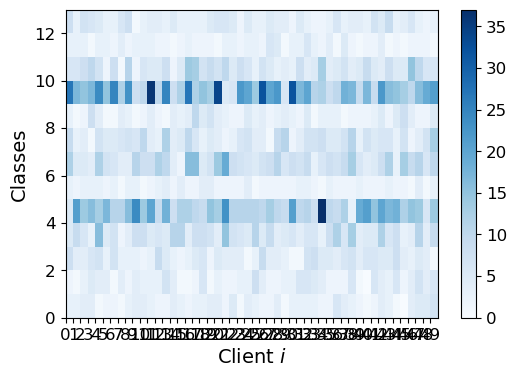

In [12]:
data_distribution_map(client_data_dir)

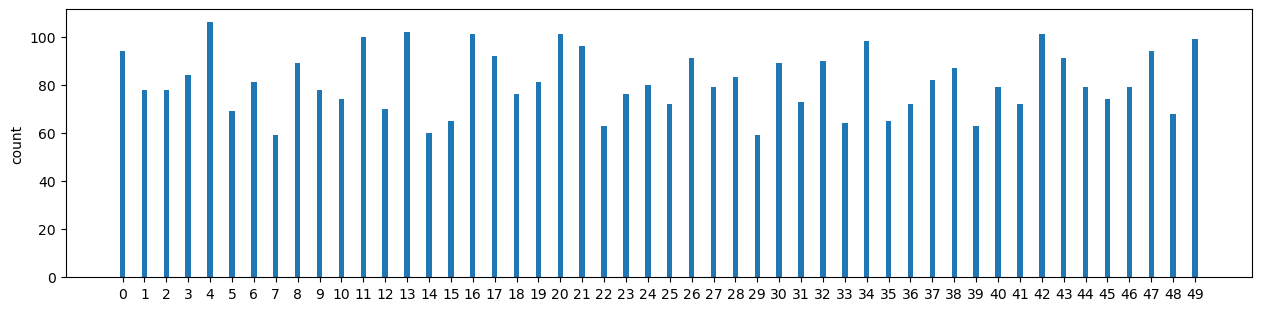

In [13]:
total_data_amount(client_data_dir)